---
title: Electron Wavefunctions
authors: [gvarnavides]
date: 2025-02-01
---

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from IPython.display import display, clear_output
import ipywidgets

import abtem
import py4DSTEM

abtem.config.set({"dask.lazy":False});

## PSF/CTF

In [2]:
symbols = [symbol for symbol in abtem.transfer.polar_symbols if symbol[0] == "C"]
nm = [(int(c[-2]), int(c[-1])) for c in symbols]
dicts = [{symbol: 50**n} for symbol, (n,m) in zip(symbols,nm)]

ctf_objects = [abtem.CTF(semiangle_cutoff=30,energy=100e3,**coefs) for coefs in dicts]
ctfs = [ctf.to_diffraction_patterns(max_angle=30).array for ctf in ctf_objects]
psfs = [ctf.to_point_spread_functions(gpts=256,extent=40).crop(extent=(10,10),offset=(15,15)).array for ctf in ctf_objects]

In [3]:
def plot_coefficients(nm, arrays):
    nrows, ncols = (5, 7)

    dpi = 72
    with plt.ioff():
        # fig = plt.figure(figsize=(675/dpi,562.5/dpi),dpi=dpi)
        fig = plt.figure(figsize=(720/dpi,600/dpi),dpi=dpi)
        
    axes = ImageGrid(
        fig,
        111,
        nrows_ncols=(nrows, ncols),
        **{"axes_pad": 0.0},
    )
    
    axes = np.array(axes).reshape((5, 7))
    
    for array, (n, m) in zip(arrays, nm):
        ax = axes[(n - 1, m)]
        rgb = py4DSTEM.visualize.Complex2RGB(array,vmin=0,vmax=1)
        ax.imshow(rgb)
    
    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
    
    for i, ax in enumerate(axes[:, 0]):
        ax.set_ylabel(f"$n={i + 1}$", fontsize=12)
    
    for i, ax in enumerate(axes[0, :]):
        ax.set_title(f"$m={i}$", fontsize=12)
        
    return fig

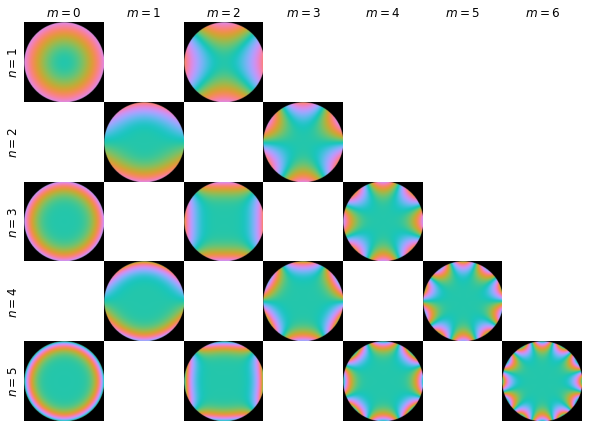

In [10]:
ctfs_fig = plot_coefficients(nm,ctfs)
# ctfs_fig.savefig("../figures/CTFs_table.png",bbox_inches="tight",transparent=True)
ctfs_fig

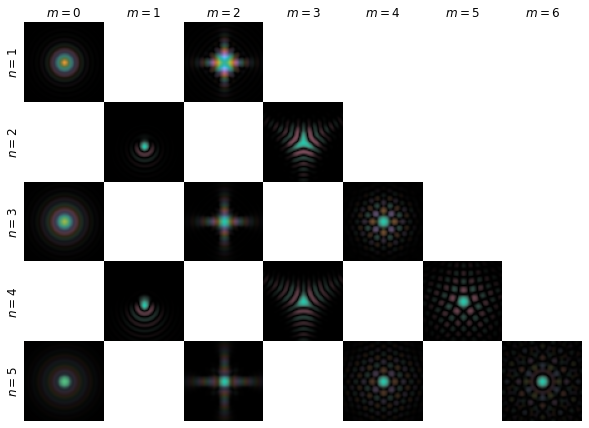

In [12]:
psfs_fig = plot_coefficients(nm,psfs)
# psfs_fig.savefig("../figures/PSFs_table.png",bbox_inches="tight",transparent=True)
psfs_fig

## Apertures

In [11]:
def return_probe_arrays(semiangle_cutoff,aberrations=None,**kwargs):
    """ """
    ctf = abtem.CTF(
        semiangle_cutoff=semiangle_cutoff,
        sampling=(0.125,0.125),
        gpts=(128,128),
        energy=300e3,
        aberration_coefficients=aberrations,
        **kwargs,
    )
    
    fourier_probe = ctf.to_diffraction_patterns(
        gpts=ctf.gpts
    ).array
    complex_probe = ctf.to_point_spread_functions(
        gpts=ctf.gpts,
        extent=ctf.extent
    ).array
    
    return ctf, fourier_probe, complex_probe

ctf, fourier_probe, complex_probe  = return_probe_arrays(
    semiangle_cutoff=20,
)

dpi = 72
with plt.ioff():
    fig,axs = plt.subplots(1,2,figsize=(675/dpi,325/dpi),dpi=dpi)

bar_common = {"Nx":128,"Ny":128,"labelsize":8}

rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
    fourier_probe,
    vmin=0,vmax=1,
)
im_fourier = axs[0].imshow(rgb_fourier_probe)
bar_fourier= bar_common | {"pixelsize":ctf.angular_sampling[0],"pixelunits":"mrad"}

rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
    complex_probe,
    vmin=0,vmax=1,
)
im_complex = axs[1].imshow(rgb_complex_probe)
bar_complex= bar_common | {"pixelsize":ctf.sampling[0],"pixelunits":r"$\AA$"}

bars = [bar_fourier, bar_complex]
titles= ["Fourier-space probe", "real-space probe"]

for ax, bar, title in zip(axs, bars, titles):
    ax.set(xticks=[],yticks=[],title=title)
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad="2.5%")
    py4DSTEM.visualize.add_colorbar_arg(ax_cb)
    py4DSTEM.visualize.add_scalebar(ax,bar)

fig.tight_layout()
fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '350px'
fig.canvas.toolbar_position = 'bottom'

In [12]:
def update_aperture(change):
    """ """
    semiangle_cutoff = change['new']
    ctf, fourier_probe, complex_probe  = return_probe_arrays(
        semiangle_cutoff=semiangle_cutoff,
    )

    rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
        fourier_probe,
        vmin=0,vmax=1,
    )
    im_fourier.set_data(rgb_fourier_probe)
    
    rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
        complex_probe,
        vmin=0,vmax=1,
    )
    im_complex.set_data(rgb_complex_probe)
    fig.canvas.draw_idle()
    return None

style = {
    'description_width': 'initial',
}

layout = ipywidgets.Layout(width='450px',height='30px')

semiangle_slider = ipywidgets.FloatSlider(
    min=5,
    max=50,
    step=0.5,
    value=20,
    layout=layout,
    style=style,
    description="convergence semi-angle [mrad]",
) 
semiangle_slider.observe(update_aperture, 'value')

In [13]:
#| label: app:convergence_angle_widget
display(
    ipywidgets.VBox(
        [
            semiangle_slider,
            fig.canvas
        ],
        layout=ipywidgets.Layout(
            align_items="center"
        )
    )
)

## Aberration Function

In [15]:
ab_ctf, ab_fourier_probe, ab_complex_probe  = return_probe_arrays(
    semiangle_cutoff=20,
    defocus=100,
    astigmatism=50,
    astigmatism_angle=np.pi/4,
)

dpi = 72
with plt.ioff():
    ab_fig,ab_axs = plt.subplots(1,2,figsize=(675/dpi,325/dpi),dpi=dpi)

ab_rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
    ab_fourier_probe,
    vmin=0,vmax=1,
)
ab_im_fourier = ab_axs[0].imshow(ab_rgb_fourier_probe)

ab_rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
    ab_complex_probe,
    vmin=0,vmax=1,
)
ab_im_complex = ab_axs[1].imshow(ab_rgb_complex_probe)

for ax, bar, title in zip(ab_axs, bars, titles):
    ax.set(xticks=[],yticks=[],title=title)
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad="2.5%")
    py4DSTEM.visualize.add_colorbar_arg(ax_cb)
    py4DSTEM.visualize.add_scalebar(ax,bar)

ab_fig.tight_layout()
ab_fig.canvas.resizable = False
ab_fig.canvas.header_visible = False
ab_fig.canvas.footer_visible = False
ab_fig.canvas.toolbar_visible = True
ab_fig.canvas.layout.width = '675px'
ab_fig.canvas.layout.height = '350px'
ab_fig.canvas.toolbar_position = 'bottom'

In [19]:
def update_aberrated_plot(
    semiangle_cutoff,
    defocus_nm,
    astigmatism_nm,
    astigmatism_angle_deg,
    coma_um,
    coma_angle_deg,
    ):
    """ """
    ab_ctf, ab_fourier_probe, ab_complex_probe  = return_probe_arrays(
        semiangle_cutoff=semiangle_cutoff,
        defocus=defocus_nm*10, # nm -> A
        astigmatism=astigmatism_nm*10, # nm -> A
        astigmatism_angle=np.deg2rad(astigmatism_angle_deg),
        coma = coma_um*1e4, # um -> A 
        coma_angle = np.deg2rad(coma_angle_deg),
    )

    ab_rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
        ab_fourier_probe,
        vmin=0,vmax=1,
    )
    ab_im_fourier.set_data(ab_rgb_fourier_probe)
    
    ab_rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
        ab_complex_probe,
        vmin=0,vmax=1,
    )
    ab_im_complex.set_data(ab_rgb_complex_probe)
    ab_fig.canvas.draw_idle()
    return None

ab_layout = ipywidgets.Layout(width='330px',height='30px')

ab_semiangle_slider = ipywidgets.FloatSlider(
    min=5,
    max=50,
    step=0.5,
    value=20,
    layout=ab_layout,
    style=style,
    description="semi-angle [mrad]",
)

ab_defocus_slider = ipywidgets.FloatSlider(
    min=-15,
    max=15,
    step=0.5,
    value=10,
    layout=ab_layout,
    style=style,
    description="defocus [nm]",
)

ab_astigmatism_slider = ipywidgets.FloatSlider(
    min=0,
    max=10,
    step=0.1,
    value=5,
    layout=ab_layout,
    style=style,
    description="astigmatism [nm]",
)

ab_coma_slider = ipywidgets.FloatSlider(
    min=0,
    max=2,
    step=0.05,
    value=0,
    layout=ab_layout,
    style=style,
    description="coma [μm]",
)

ab_astigmatism_angle_slider = ipywidgets.FloatSlider(
    min=-90,
    max=90,
    step=1,
    value=45,
    layout=ab_layout,
    style=style,
    description="astigmatism angle [°]",
)

ab_coma_angle_slider = ipywidgets.FloatSlider(
    min=-180,
    max=180,
    step=1,
    value=180,
    layout=ab_layout,
    style=style,
    description="coma angle [°]",
)

ipywidgets.interactive_output(
    update_aberrated_plot,
    {
        'semiangle_cutoff': ab_semiangle_slider,
        'defocus_nm': ab_defocus_slider,
        'astigmatism_nm': ab_astigmatism_slider,
        'astigmatism_angle_deg': ab_astigmatism_angle_slider,
        'coma_um': ab_coma_slider,
        'coma_angle_deg': ab_coma_angle_slider
    }
)
None

In [20]:
#| label: app:aberrations_widget
display(
    ipywidgets.VBox(
        [
            ipywidgets.HBox([ab_semiangle_slider,ab_defocus_slider]),
            ipywidgets.HBox([ab_astigmatism_slider,ab_astigmatism_angle_slider]),
            ipywidgets.HBox([ab_coma_slider,ab_coma_angle_slider]),
            ab_fig.canvas,
        ],
        layout=ipywidgets.Layout(
            align_items="center"
        )
    )
)